### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [137]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.style.use('ggplot')

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

from collections import Counter
from functools import reduce, partial
from operator import add

In [410]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] <= threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    

    def __get_criterion(self, y):
        """
        Выдает значение критерия информативности (impurity criterion)
        в зависимости от заданного в self.criterion 
        """
        len_ = y.shape[0]
        
        if len_ == 0:
            return 0
        
        _, probabs = np.unique(y, return_counts=True)
        probabs = probabs / len_
        
        if self.criterion == 'entropy':
            criterion = reduce(add, map(lambda p: -p*np.log2(p), probabs))
            
        elif self.criterion == 'gini':
#             здесь reduce работает быстрее numpy
            criterion = reduce(add, map(lambda p: p*(1-p), probabs))
#             criterion = np.sum(probabs*(1-probabs))
            
        elif self.criterion == 'mistake':
            criterion = 1 - max(probabs)
            
        return criterion
        
    def __get_quality(self, y_left, y_right):
        """
        Выдает значение функционала качества для полученного разбиения
        """
        left_criterion = self.__get_criterion(y_left)
        right_criterion = self.__get_criterion(y_right)
        whole_criterion = self.__get_criterion(np.concatenate((y_left, y_right)))
        len_ = y_left.shape[0] + y_right.shape[0]
        return whole_criterion - y_left.shape[0]*left_criterion/len_ - \
                y_right.shape[0]*right_criterion/len_

    def __div_get_qual(self, x, y, feature_id, threshold):
        """
        Выдает значение функционала качества при получении порога и признака
        """
        
        left_mask = x[:, feature_id] <= threshold
        right_mask = ~left_mask
        
        return self.__get_quality(y[left_mask], y[right_mask]) 
    
    
    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используются разные impurity в зависимости от self.criterion
        """
        
        best_quality = 0
        best_threshold = 0
        best_id = 0
        
        for feature_id in range(x.shape[1]):
            features = np.unique(x[:, feature_id])
            
            threshold = max(features, key=lambda th: self.__div_get_qual(x, y, feature_id, th))
            quality = self.__div_get_qual(x, y, feature_id, threshold)
                
            if quality > best_quality:
                best_quality = quality
                best_threshold = threshold
                best_id = feature_id
                    
        self.__feature_importances[best_id] += best_quality
        
        return best_id, best_threshold        
        

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        if x.shape[0] == 0:
            pass
        
        elif depth + 1 == self.max_depth or \
                x.shape[0] < self.min_samples_split or \
                np.unique(y).shape[0] == 1:
            vals, counts = np.unique(y, return_counts=True)
            ind = np.argmax(counts)
            len_ = y.shape[0]
            self.tree[node_id] = (self.LEAF_TYPE, vals[ind], counts[ind]/len_)
        else:
            feature_id, threshold = self.__find_threshold(x, y)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold)
            self.tree[node_id] = (self.NON_LEAF_TYPE, feature_id, threshold)
            self.__fit_node(x_left, y_left, 2*node_id+1, depth+1)
            self.__fit_node(x_right, y_right, 2*node_id+2, depth+1)
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        
        try:
            x = x.values
        except AttributeError:
            pass
        
        self.__feature_importances = {}
        
        for i in range(x.shape[1]):
            self.__feature_importances[i] = 0
            
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 
        return self

    def __predict_class(self, x, node_id, class_=True):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        Предсказываем либо класс, либо вероятность в 
        зависимости от параметра class_
        """
        node = self.tree[node_id]
        
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] <= threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            if class_==True:
                return node[1]
            else:
                return node[2]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        
        try:
            X = X.values
        except AttributeError:
            pass
        
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.__feature_importances

In [430]:
clf = DecisionTreeClassifier(min_samples_split=2)
my_clf = MyDecisionTreeClassifier(min_samples_split=2, max_depth=5)

In [435]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [436]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
0.9444444444444444


In [437]:
my_clf.get_feature_importance()

{0: 0.375,
 1: 0.75,
 2: 0,
 3: 0,
 4: 0.07133058984910842,
 5: 0,
 6: 0.3469589202392676,
 7: 0,
 8: 0,
 9: 0.33125646571992845,
 10: 0,
 11: 0.033304128335106396,
 12: 0.2528337413594469}

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [438]:
%time clf.fit(X_train, y_train)

Wall time: 2 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [439]:
%time my_clf.fit(X_train, y_train)

Wall time: 572 ms


Скорее всего, чтобы добиться ускорения, реализовывать нужно было совсем иначе. Но я так и не понял как.

## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


\# Большая часть обработки взята из семинара

In [173]:
df = pd.read_csv('./data/speed-dating-experiment/Speed Dating Data.csv', encoding='latin1')

In [174]:
df

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,22.0,1,44,2,21,22,14,10.0,5,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8374,552,22.0,1,44,2,21,22,13,10.0,4,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0
8376,552,22.0,1,44,2,21,22,3,10.0,16,...,8.0,5.0,7.0,6.0,7.0,9.0,5.0,9.0,5.0,6.0


In [175]:
df.shape

(8378, 195)

In [176]:
df = df.iloc[:, :97]

Рассмотрим нужные признаки по очереди

#### iid
unique subject number, group(wave id gender)

Кажется это идентификатор

In [177]:
df.iid.nunique()

551

#### id 

Subject number within wave

Кажется это нам не нужно

In [178]:
df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)

#### gender

* Female=0
* Male=1

In [179]:
df.drop_duplicates(subset=['iid']).gender.value_counts()

1    277
0    274
Name: gender, dtype: int64

#### condtn:
* 1=limited choice
* 2=extensive choice

???

In [180]:
df.drop_duplicates(subset=['iid']).condtn.value_counts()

2    386
1    165
Name: condtn, dtype: int64

In [181]:
df = df.drop(['condtn'], axis=1)

#### wave

Пока оставим в таблице, но в качестве признака рассматривать не будем

In [182]:
df.wave.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21], dtype=int64)

#### round:

number of people that met in wave

Можно взять в качестве признака..

In [183]:
df = df.drop(['round'], axis=1)

#### position:
station number where met partner 

#### positin1
station number where started 

Выкидываем

In [184]:
df.drop_duplicates('iid')['position'].isnull().sum()

0

In [185]:
df = df.drop(['position', 'positin1'], axis=1)

#### order: 		
the number of date that night when met partner


In [186]:
df = df.drop(['order'], axis=1)

#### partner: 	
partner’s id number the night of event

Это можно удались

#### pid: 		
partner’s iid number
А вот это важно


In [187]:
df = df.drop(['partner'], axis=1)

##### match		
* 1=yes, 
* 0=no

Наш таргет

#### int_corr:	
correlation between participant’s and partner’s ratings of interests in 		

#### samerace:  	
participant and the partner were the same race. 1= yes, 0=no

Придумали за нас признаки)

#### age_o:		
age of partner
#### race_o:		
race of partner
#### pf_o_att: 	
partner’s stated preference at Time 1 (attr1_1) for all 6 attributes
#### dec_o: 		
decision of partner the night of event
#### attr_o: 		
rating by partner the night of the event, for all 6 attributes

Убираем

In [188]:
df.drop_duplicates('iid')['met_o'].isnull().sum()

21

In [189]:
feats_o = [f for f in df.columns.values if '_o' in f]
# df.corr().match.sort_values(ascending=False)
df_corr = df[feats_o]
df_corr['match'] = df['match']
df_corr.corr().match.sort_values(ascending=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


match       1.000000
dec_o       0.522326
like_o      0.305853
fun_o       0.277700
shar_o      0.270840
attr_o      0.260837
prob_o      0.255574
intel_o     0.169448
sinc_o      0.164523
amb_o       0.139927
pf_o_fun    0.041483
pf_o_att    0.015663
pf_o_int    0.013761
pf_o_amb   -0.004650
race_o     -0.013088
pf_o_sin   -0.032391
age_o      -0.035865
pf_o_sha   -0.048399
go_out     -0.060526
met_o      -0.106569
Name: match, dtype: float64

In [190]:
# df = df.drop(['age_o', 'race_o', 'pf_o_att', 
#               'pf_o_sin', 'pf_o_int',
#               'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
#               'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
#               'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
#              axis=1)
df = df.drop(['dec_o', 'intel_o', 'sinc_o',
'amb_o',
'pf_o_fun',
'pf_o_att',
'pf_o_int',
'pf_o_amb',
'race_o',
'pf_o_sin',
'age_o',
'pf_o_sha',
'met_o'], axis=1)

In [191]:
df.drop_duplicates('iid')['like_o'].isnull().sum()

11

In [192]:
df = df.dropna(subset=['like_o'])

In [193]:
df = df.dropna(subset=['fun_o'])

In [194]:
df = df.dropna(subset=['shar_o'])

In [195]:
df = df.dropna(subset=['attr_o'])

In [196]:
df = df.dropna(subset=['prob_o'])

In [197]:
df.drop_duplicates(subset=['iid']).gender.value_counts()

1    277
0    274
Name: gender, dtype: int64

#### age
оставляем

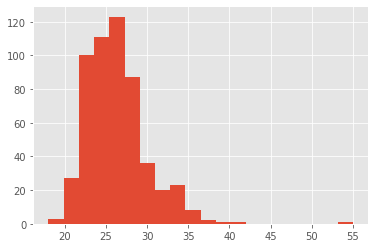

In [198]:
df.drop_duplicates(subset=['iid']).age.hist(bins=20)

In [199]:
df.drop_duplicates('iid').age.isnull().sum()

8

In [200]:
df = df.dropna(subset=['age'])

#### field:		
field of study  

#### field_cd: 	
field coded 


In [201]:
for i, group in df.groupby('field_cd'):
    print('=' * 10)
    print('Field Code {}'.format(i))
    print(group.field.unique())

Field Code 1.0
['Law' 'law' 'LAW' 'Law and Social Work'
 'Law and English Literature (J.D./Ph.D.)' 'Intellectual Property Law'
 'Law/Business']
Field Code 2.0
['Economics' 'Mathematics' 'Statistics' 'math' 'Mathematics, PhD' 'Stats'
 'math of finance' 'Math']
Field Code 3.0
['Psychology' 'Speech Language Pathology' 'Speech Languahe Pathology'
 'Educational Psychology' 'Organizational Psychology' 'psychology'
 'Communications' 'Sociology' 'psychology and english' 'theory'
 'Health policy' 'Clinical Psychology' 'Sociology and Education'
 'sociology' 'Anthropology/Education' 'speech pathology'
 'Speech Pathology' 'Anthropology' 'School Psychology' 'anthropology'
 'Counseling Psychology' 'African-American Studies/History']
Field Code 4.0
['Medicine' 'Art History/medicine'
 'Sociomedical Sciences- School of Public Health' 'Epidemiology'
 'GS Postbacc PreMed' 'medicine']
Field Code 5.0
['Operations Research' 'Mechanical Engineering' 'Engineering'
 'Electrical Engineering' 'Operations Researc

In [202]:
df.field_cd.isnull().sum()

15

In [203]:
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)

In [205]:
df = df.drop(['field'], axis=1)

Надо же как-то закодировать field_cd!

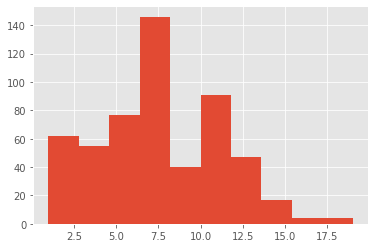

In [206]:
df.drop_duplicates('iid').field_cd.hist()

In [207]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

fields = ohe.fit_transform(df['field_cd'].values.reshape(-1,1)).toarray()

s='field_'
for i in range(fields.T.shape[0]):
    df[s+str(i+1)] = fields.T[i]
df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,iid,gender,wave,pid,match,int_corr,samerace,attr_o,fun_o,shar_o,...,field_10,field_11,field_12,field_13,field_14,field_15,field_16,field_17,field_18,field_19
0,1,0,1,11.0,0,0.14,0,6.0,8.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1,12.0,0,0.54,0,7.0,7.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,1,13.0,1,0.16,1,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,1,14.0,1,0.61,0,7.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,1,15.0,1,0.21,0,8.0,6.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,1,21,526.0,0,0.64,0,10.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8374,552,1,21,527.0,0,0.71,0,6.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8375,552,1,21,528.0,0,-0.46,0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8376,552,1,21,529.0,0,0.62,0,5.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [208]:
df = df.drop('field_cd', axis=1)

#### undergrd:  	
school attended for undergraduate degree

Пока выкинем

In [209]:
df.undergra.value_counts().head()

UC Berkeley    92
Harvard        90
Columbia       72
Yale           70
NYU            66
Name: undergra, dtype: int64

In [210]:
df = df.drop(['undergra'], axis=1)

#### mn_sat: 	
Median SAT score for the undergraduate institution where attended.  			

In [211]:
df.mn_sat.value_counts().head()

1,400.00    347
1,430.00    223
1,290.00    170
1,450.00    139
1,340.00    122
Name: mn_sat, dtype: int64

In [212]:
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)

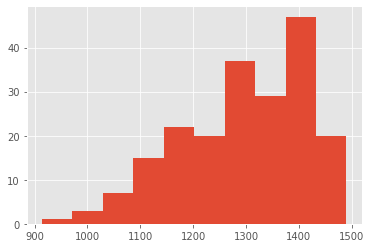

In [213]:
df.drop_duplicates('iid').mn_sat.hist()

In [214]:
df.drop_duplicates('iid').mn_sat.isnull().sum()

342

In [215]:
df

,iid,gender,wave,pid,match,int_corr,samerace,attr_o,fun_o,shar_o,...,field_10,field_11,field_12,field_13,field_14,field_15,field_16,field_17,field_18,field_19
0,1,0,1,11.0,0,0.14,0,6.0,8.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1,12.0,0,0.54,0,7.0,7.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,1,13.0,1,0.16,1,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,1,14.0,1,0.61,0,7.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,1,15.0,1,0.21,0,8.0,6.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,1,21,526.0,0,0.64,0,10.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8374,552,1,21,527.0,0,0.71,0,6.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8375,552,1,21,528.0,0,-0.46,0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8376,552,1,21,529.0,0,0.62,0,5.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [216]:
df = df.drop(['mn_sat'], axis=1)
# df = df.dropna(subset=['mn_sat'])

In [217]:
df

,iid,gender,wave,pid,match,int_corr,samerace,attr_o,fun_o,shar_o,...,field_10,field_11,field_12,field_13,field_14,field_15,field_16,field_17,field_18,field_19
0,1,0,1,11.0,0,0.14,0,6.0,8.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0,1,12.0,0,0.54,0,7.0,7.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,1,13.0,1,0.16,1,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,1,14.0,1,0.61,0,7.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0,1,15.0,1,0.21,0,8.0,6.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,1,21,526.0,0,0.64,0,10.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8374,552,1,21,527.0,0,0.71,0,6.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8375,552,1,21,528.0,0,-0.46,0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8376,552,1,21,529.0,0,0.62,0,5.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### tuition: 	
Tuition listed for each response to undergrad in Barron’s 25th Edition college profile book.

In [218]:
df.tuition.value_counts().head()

26,908.00    203
26,019.00    147
15,162.00    119
25,380.00     92
26,062.00     91
Name: tuition, dtype: int64

In [219]:
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)

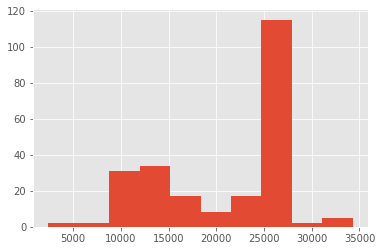

In [220]:
df.drop_duplicates('iid').tuition.hist()

In [221]:
df.drop_duplicates('iid').tuition.isnull().sum()

310

In [222]:
df = df.drop(['tuition'], axis=1)
# df = df.dropna(subset=['tuition'])

#### race:
* Black/African American=1
* European/Caucasian-American=2
* Latino/Hispanic American=3
* Asian/Pacific Islander/Asian-American=4
* Native American=5
* Other=6


In [223]:
df[df['race'] == 5]['iid'].count()

0

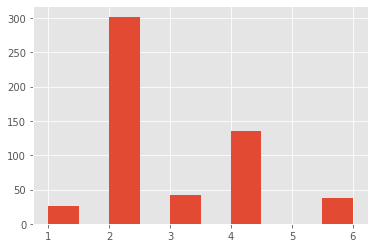

In [224]:
df.drop_duplicates('iid')['race'].hist()

In [225]:
ohe = OneHotEncoder()
races = ohe.fit_transform(df['race'].values.reshape(-1,1)).toarray().T

df['black'] = races[0]
df['european'] = races[1]
df['latino'] = races[2]
df['asian'] = races[3]
df['other'] = races[4]

# mask = df['race'] == 2
# european = np.arange(mask.shape[0])
# pos = european[mask]
# european = np.zeros(mask.shape[0])
# european[pos] = 1
# df['european'] = european

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [226]:
df = df.drop('race', axis=1)

#### imprace:
How important is it to you (on a scale of 1-10) that a person you date be of the same racial/ethnic background?

#### imprelig:
 How important is it to you (on a scale of 1-10) that a person you date be of the same religious background?


In [227]:
df.drop_duplicates('iid').imprace.isnull().sum()

1

In [228]:
df.drop_duplicates('iid').imprelig.isnull().sum()

1

In [229]:
# Что делать?
df = df.dropna(subset=['imprelig', 'imprace'])

In [230]:
# relig = np.zeros(df.shape[0])
# less = df['imprelig'] > 4
# relig[less] = 1
# df['imprelig'] = relig

In [231]:
# race = np.zeros(df.shape[0])
# less = df['imprace'] > 4
# race[less] = 1
# df['imprace'] = race

#### from:
Where are you from originally (before coming to Columbia)? 

#### zipcode:
What was the zip code of the area where you grew up? 

Выкидываем

In [232]:
df = df.drop(['from', 'zipcode'], axis=1)

#### income

In [233]:
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)

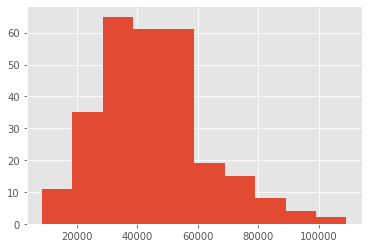

In [234]:
df.drop_duplicates('iid').loc[:, 'income'].hist()

In [235]:
df.drop_duplicates('iid').loc[:, 'income'].isnull().sum()

261

In [236]:
# df = df.dropna(subset=['income'])
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)

#### goal:
    What is your primary goal in participating in this event? 
	Seemed like a fun night out=1
	To meet new people=2
	To get a date=3
	Looking for a serious relationship=4
	To say I did it=5
	Other=6

#### date:
    In general, how frequently do you go on dates? 
	Several times a week=1
	Twice a week=2
	Once a week=3
	Twice a month=4
	Once a month=5
	Several times a year=6
	Almost never=7

#### go out:
    How often do you go out (not necessarily on dates)?
	Several times a week=1
	Twice a week=2
	Once a week=3
	Twice a month=4
	Once a month=5
	Several times a year=6
	Almost never=7

Как бы вы предложили закодировать эти переменные?

In [237]:
df = df.dropna(subset=['date'])

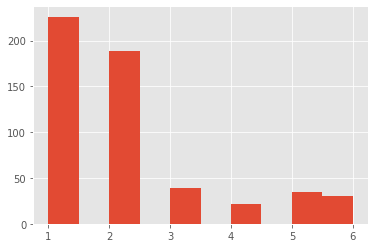

In [238]:
df.drop_duplicates('iid')['goal'].hist()

In [239]:
# go_out = np.zeros(df.shape[0])
# more = df['go_out'] > 3
# go_out[more] = 1
# df['go_out'] = go_out

In [240]:
# goal = np.zeros(df.shape[0])
# more = df['goal'] > 2
# goal[more] = 1
# df['goal'] = goal

In [241]:
ohe = OneHotEncoder()

goals = ohe.fit_transform(df['goal'].values.reshape(-1,1)).toarray().T

s='goal_'
for i in range(goals.shape[0]):
    df[s+str(i+1)] = goals[i]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [242]:
ohe = OneHotEncoder()

dates = ohe.fit_transform(df['date'].values.reshape(-1,1)).toarray().T

s='date_'
for i in range(dates.shape[0]):
    df[s+str(i+1)] = dates[i]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [243]:
ohe = OneHotEncoder()

go_outs = ohe.fit_transform(df['go_out'].values.reshape(-1,1)).toarray().T

s='go_out_'
for i in range(go_outs.shape[0]):
    df[s+str(i+1)] = go_outs[i]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [244]:
df = df.drop(['goal', 'date', 'go_out'], axis=1)

#### career:
What is your intended career?

#### career_c: 
career coded 

Работаем аналогично field и field_cd

In [245]:
for i, group in df.groupby('career_c'):
    print('=' * 10)
    print('Career Code {}'.format(i))
    print(group.career.unique())

Career Code 1.0
['lawyer/policy work' 'lawyer' 'Law' 'Corporate Lawyer' 'Lawyer'
 'Corporate attorney' 'law' 'Intellectual Property Attorney' 'LAWYER'
 'attorney' 'Lawyer or professional surfer' 'lawyer/gov.position'
 'Law or finance' 'IP Law' 'Academic (Law)' 'Private Equity' 'attorney?'
 'Corporate law' 'tax lawyer' 'Business/Law' 'Assistant District Attorney']
Career Code 2.0
['Academia, Research, Banking, Life' 'academics or journalism' 'Professor'
 'Academic' 'academia' 'teacher' 'industrial scientist'
 'teaching and then...' 'Professor of Media Studies'
 'Education Administration' 'Academic or Research staff'
 'University Professor' 'Research Scientist'
 'research in industry or academia' 'Teacher/Professor'
 'no idea, maybe a professor' 'a research position' 'professor' 'teaching'
 'engineering professional' 'research' 'Neuroscientist/Professor'
 'Education' 'Professor and Government Official'
 'physicist, probably academia' 'college art teacher' 'academic'
 'Research scientist,

In [246]:
df.career_c.isnull().sum()

52

In [247]:
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)

In [248]:
df = df.drop(['career'], axis=1)

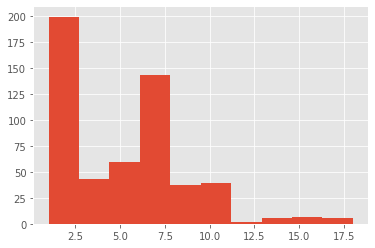

In [249]:
df.drop_duplicates('iid')['career_c'].hist()

In [250]:
# Теперь это надо закодировать
ohe = OneHotEncoder()

fields = ohe.fit_transform(df['career_c'].values.reshape(-1,1)).toarray()

s='career_'
for i in range(fields.T.shape[0]):
    df[s+str(i+1)] = fields.T[i]
df

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,iid,gender,wave,pid,match,int_corr,samerace,attr_o,fun_o,shar_o,...,career_9,career_10,career_11,career_12,career_13,career_14,career_15,career_16,career_17,career_18
0,1,0,1,11.0,0,0.14,0,6.0,8.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0,1,12.0,0,0.54,0,7.0,7.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0,1,13.0,1,0.16,1,10.0,10.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,1,14.0,1,0.61,0,7.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1,0,1,15.0,1,0.21,0,8.0,6.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,1,21,526.0,0,0.64,0,10.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8374,552,1,21,527.0,0,0.71,0,6.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8375,552,1,21,528.0,0,-0.46,0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8376,552,1,21,529.0,0,0.62,0,5.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [251]:
df = df.drop('career_c', axis=1)

How interested are you in the following activities, on a scale of 1-10?
    
    sports: Playing sports/ athletics
    tvsports: Watching sports
    excersice: Body building/exercising
    dining: Dining out
    museums: Museums/galleries
    art: Art
    hiking:  Hiking/camping
    gaming: Gaming
    clubbing: Dancing/clubbing
    reading: Reading
    tv: Watching TV
    theater: Theater
    movies: Movies
    concerts: Going to concerts
    music: Music
    shopping: Shopping
    yoga: Yoga/meditation

По большому счету с этими признаками можно придумать много чего.. Например у нас уже есть признак, который считает корреляцию между интересами пар. Пока мы все их выкинем

In [252]:
df['reading']

0       6.0
1       6.0
2       6.0
3       6.0
4       6.0
       ... 
8373    8.0
8374    8.0
8375    8.0
8376    8.0
8377    8.0
Name: reading, Length: 7064, dtype: float64

In [253]:
df.loc[:, ['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga']
      ].isnull().sum()

sports      0
tvsports    0
exercise    0
dining      0
museums     0
art         0
hiking      0
gaming      0
clubbing    0
reading     0
tv          0
theater     0
movies      0
concerts    0
music       0
shopping    0
yoga        0
dtype: int64

In [254]:
# df = df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
#        'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1)

#### exphappy:
Overall, on a scale of 1-10, how happy do you expect to be with the people you meet 
during the speed-dating event?

#### expnum: 
Out of the 20 people you will meet, how many do you expect will be interested in dating you? 


In [255]:
df.drop_duplicates('iid').exphappy.isnull().sum()

0

In [256]:
df.drop_duplicates('iid').expnum.isnull().sum()

416

In [257]:
df = df.drop(['expnum'], axis=1)
# df = df.dropna(subset=['expnum'])

### Attr1

We want to know what you look for in the opposite sex. 
Waves 6-9: Please rate the importance of the following attributes in a potential date on a scale of 1-10 (1=not at all important, 10=extremely important):
Waves 1-5, 10-21: You have 100 points to distribute among the following attributes -- give more points to those attributes that are more important in a potential date, and fewer points to those attributes that are less important in a potential date.  Total points must equal 100.

attr1_1 
Attractive

sinc1_1
Sincere

intel1_1
Intelligent

fun1_1
Fun

amb1_1
Ambitious

shar1_1
Has shared interests/hobbies


In [258]:
feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 99)

idx = ((temp.wave >= 6) & (temp.wave <= 9))

df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
(df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

Проведите аналогичную работу для признаков `attr2`

### Attr2

In [259]:
feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)

idx = ((temp.wave >= 6) & (temp.wave <= 9))

df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
(df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

## Attr4

In [260]:
# feat = ['iid', 'wave', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1']

# temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

# temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

# idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)

# idx = ((temp.wave >= 6) & (temp.wave <= 9))

# df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1']].sum(axis=1)

# df.loc[:, ['attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1']] = \
# (df.loc[:, ['attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

## Attr5

In [261]:
feat = ['iid', 'wave', 'attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]

temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)

idx = ((temp.wave < 6) | (temp.wave > 9)) & (temp.totalsum < 90) & (temp.totalsum != 0)

idx = ((temp.wave >= 6) & (temp.wave <= 9))

df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1']].sum(axis=1)

df.loc[:, ['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1']] = \
(df.loc[:, ['attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1']].T/df.loc[:, 'temp_totalsum'].T).T * 100

In [262]:
df = df.drop(['temp_totalsum'], axis=1)

Теперь создалим таблицу с мужчинами, таблицу с женщинами с сджоиним их

In [264]:
df = df.drop(['wave'], axis=1)

In [265]:
df.columns.values

array(['iid', 'gender', 'pid', 'match', 'int_corr', 'samerace', 'attr_o',
       'fun_o', 'shar_o', 'like_o', 'prob_o', 'age', 'imprace',
       'imprelig', 'income', 'sports', 'tvsports', 'exercise', 'dining',
       'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv',
       'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga',
       'exphappy', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1',
       'shar1_1', 'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1',
       'shar4_1', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1',
       'shar2_1', 'attr3_1', 'sinc3_1', 'fun3_1', 'intel3_1', 'amb3_1',
       'attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1', 'amb5_1', 'field_1',
       'field_2', 'field_3', 'field_4', 'field_5', 'field_6', 'field_7',
       'field_8', 'field_9', 'field_10', 'field_11', 'field_12',
       'field_13', 'field_14', 'field_15', 'field_16', 'field_17',
       'field_18', 'field_19', 'black', 'european', 'latino', 'asian',
       'o

In [266]:
df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
                                 .drop(['gender'], axis=1)\
                                 .dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid'])\
                                   .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
        
df_female.columns = df_female.columns + '_f'

In [267]:
df_female

,iid_f,pid_f,attr_o_f,fun_o_f,shar_o_f,like_o_f,prob_o_f,age_f,imprace_f,imprelig_f,...,career_9_f,career_10_f,career_11_f,career_12_f,career_13_f,career_14_f,career_15_f,career_16_f,career_17_f,career_18_f
3409,234,244.0,6.0,8.0,3.0,3.0,2.0,22.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3418,235,244.0,9.0,8.0,5.0,6.0,4.0,23.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3427,236,244.0,4.0,2.0,1.0,4.0,2.0,24.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3436,237,244.0,2.0,4.0,1.0,3.0,7.0,34.0,10.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3445,238,244.0,8.0,8.0,7.0,8.0,5.0,27.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7762,525,531.0,5.0,5.0,5.0,3.0,1.0,24.0,2.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7784,526,531.0,5.0,10.0,5.0,5.0,1.0,26.0,5.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7806,527,531.0,5.0,5.0,1.0,1.0,1.0,24.0,5.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7850,529,531.0,5.0,5.0,8.0,3.0,3.0,22.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [268]:
from sklearn.model_selection import train_test_split

In [269]:
X = df_male.merge(df_female, left_on='pid', right_on='iid_f', how='inner')

X = X.drop(['iid', 'iid_f', 'pid', 'pid_f'], axis=1)

Counter(X['match'])

Counter({0: 1661, 1: 327})

In [270]:
from sklearn.model_selection import train_test_split

In [271]:
X

,match,int_corr,samerace,attr_o,fun_o,shar_o,like_o,prob_o,age,imprace,...,career_9_f,career_10_f,career_11_f,career_12_f,career_13_f,career_14_f,career_15_f,career_16_f,career_17_f,career_18_f
0,0,0.43,0,4.0,7.0,2.0,5.0,2.0,27.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.46,0,7.0,7.0,5.0,7.0,4.0,28.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.05,0,4.0,6.0,7.0,6.0,2.0,32.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.44,0,4.0,5.0,2.0,4.0,1.0,25.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.23,1,5.0,8.0,2.0,6.0,3.0,27.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,0,0.35,0,5.0,7.0,2.0,4.0,6.0,23.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,0,-0.12,1,7.0,6.0,1.0,5.0,5.0,24.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985,1,0.48,1,7.0,7.0,6.0,6.0,5.0,28.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,1,0.65,1,5.0,9.0,2.0,7.0,7.0,30.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Adding new features

Пробуем объединить поля детельности - гуманитарные против технических и медицины

In [272]:
non_humanit = ['field_2', 'field_4', 'field_5', 'field_10']
cond = np.any(X[non_humanit] == 1, axis=1)

feat = np.zeros(X.shape[0])
all_inds = np.arange(X.shape[0])
nec_inds = all_inds[cond]

feat[nec_inds] = 1

print(Counter(feat))

X['non_humanit'] = feat

Counter({0.0: 1292, 1.0: 696})


Примерно аналогичное с карьерой

In [273]:
career = ['career_2', 'career_4', 'career_5']
cond = np.any(X[career] == 1, axis=1)

feat = np.zeros(X.shape[0])
all_inds = np.arange(X.shape[0])
nec_inds = all_inds[cond]

feat[nec_inds] = 1

print(Counter(feat))

X['eng_med_car'] = feat

Counter({0.0: 1332, 1.0: 656})


Совпадение по полям деятельности

In [274]:
feat = np.zeros(X.shape[0])
all_inds = np.arange(X.shape[0])
for i in range(1, 20):
    field = 'field_' + str(i)
    mask = X[field] == 1
    nec_inds = all_inds[mask & (X[field] == X[field + '_f'])]
    feat[nec_inds] = 1

In [275]:
Counter(feat)

Counter({0.0: 1798, 1.0: 190})

In [276]:
X['new_feat'] = feat

Пробуем проанализировать интересы и результаты опроса (спойлер - это не сработает)

In [277]:
cond_0 = abs(X['attr1_1'] - X['attr1_1_f']) < 20
cond_1 = X['shar1_1'] > 10
cond_2 = X['shar1_1_f'] > 10
cond_3 = X['amb3_1_f'] > 7
cond_4 = X['intel3_1'] > 7
cond_5 = X['age'] > X['age_f']
cond_6 = abs(X['age'] - X['age_f']) < 5
cond_7 = abs(X['theater'] - X['theater_f']) < 3


cond = cond_1 & cond_2 & cond_5 & cond_3

feat = np.zeros(X.shape[0])
all_inds = np.arange(X.shape[0])
nec_inds = all_inds[cond]

feat[nec_inds] = 1

X['new_feat'] = feat

In [278]:
# X = X.drop(['like_o', 'fun_o', 'shar_o', 'prob_o', 'attr_o'], axis=1)
# X = X.drop(['like_o_f', 'fun_o_f', 'shar_o_f', 'prob_o_f', 'attr_o_f'], axis=1)

In [279]:
# X_0 = X[X['match'] == 0].sample(n=300, random_state=234)
# X_1 = X[X['match'] == 1]
# X = pd.concat([X_0, X_1], axis=0)
# X = X.sample(n=X.shape[0], random_state=567)

In [280]:
y = X['match'].values
X = X.drop('match', axis=1)

In [283]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

In [285]:
from collections import Counter
Counter(y)

Counter({0: 1661, 1: 327})

In [313]:
model = MyDecisionTreeClassifier(max_depth=5)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3456)
model.fit(x_train, y_train)

In [314]:
model.tree

{0: (0, 5, 6.0),
 1: (0, 120, 9.0),
 3: (0, 5, 5.0),
 7: (0, 2, 9.0),
 15: (1, 0, 0.9858490566037735),
 16: (1, 0, 0.5),
 8: (0, 135, 8.0),
 17: (1, 0, 0.9070631970260223),
 18: (1, 1, 1.0),
 4: (0, 125, 6.0),
 9: (0, 4, 6.0),
 19: (1, 0, 1.0),
 20: (1, 0, 0.5714285714285714),
 10: (0, 3, 7.0),
 21: (1, 0, 0.7),
 22: (1, 1, 1.0),
 2: (0, 6, 6.0),
 5: (0, 177, 0.0),
 11: (0, 80, 0.0),
 23: (1, 0, 0.8327402135231317),
 24: (1, 1, 0.5294117647058824),
 12: (0, 54, 24.242424242424242),
 25: (1, 1, 0.9),
 26: (1, 0, 0.75),
 6: (0, 140, 8.0),
 13: (0, 171, 18.91891891891892),
 27: (1, 0, 1.0),
 28: (1, 1, 0.5882352941176471),
 14: (0, 4, 9.0),
 29: (1, 0, 0.753968253968254),
 30: (1, 1, 0.7272727272727273)}

In [315]:
feat_imps = np.array(list(model.get_feature_importance().values()))
inds = np.argsort(feat_imps)[::-1]
used_inds_sorted = inds[feat_imps[inds] > 0]

print('Признаки в порядке убывания важности:')
for feat in X.columns[used_inds_sorted].values:
    print(feat)
    
feat_imps[inds]

Признаки в порядке убывания важности:
intel5_1
fun_o
shar_o
intel5_1_f
imprace_f
movies_f
like_o
field_4_f
prob_o
other
gaming_f
fun_o_f
attr_o


array([0.17244898, 0.1017301 , 0.08723975, 0.0515619 , 0.0469224 ,
       0.03237468, 0.02902855, 0.02374877, 0.01737724, 0.01411024,
       0.01205449, 0.00486499, 0.00220602, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [316]:
y_pred_ = model.predict(x_test)
Counter(y_pred_)

Counter({0: 576, 1: 81})

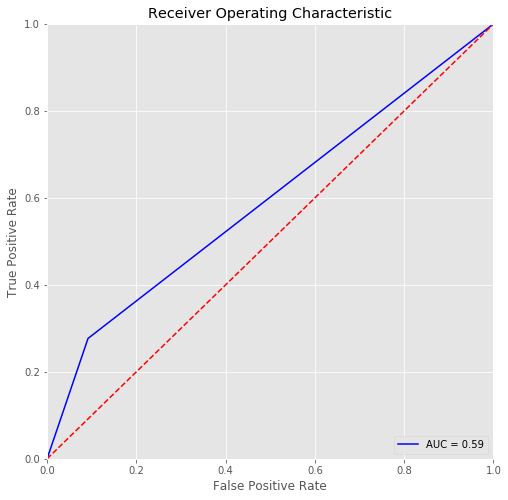

In [317]:
import sklearn.metrics as metrics
fpr, tpr, thr = metrics.roc_curve(y_test, y_pred_)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Сравним результат дерева MyTreeClassifier с работой дерева из библиотеки sklearn

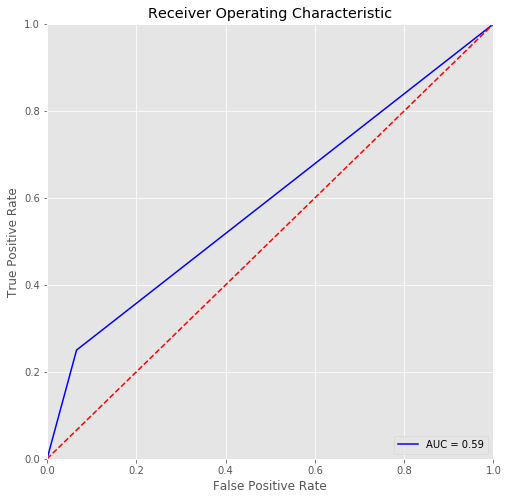

In [318]:
model2 = DecisionTreeClassifier(max_depth=5)
model2.fit(x_train, y_train)
y_pred_ = model2.predict(x_test)

fpr, tpr, thr = metrics.roc_curve(y_test, y_pred_)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

1. Оптимальный критерий информативности

In [397]:
from sklearn.model_selection import KFold

def get_roc_auc_mean(**kwargs):
    kf = KFold(n_splits=3)
    mclsf = MyDecisionTreeClassifier(**kwargs)
    roc_auc_mean = 0

    X_mass = X.values

    for train_index, val_index in kf.split(X_mass):
        data_train, data_val = X_mass[train_index], X_mass[val_index]
        target_train, target_val = y[train_index], y[val_index]
        mclsf.fit(data_train, target_train)
        pred = mclsf.predict(data_val)
        fpr, tpr, thr = metrics.roc_curve(target_val, pred)
        roc_auc = metrics.auc(fpr, tpr)
        roc_auc_mean += roc_auc

    roc_auc_mean /= 3
    
    return roc_auc_mean

In [411]:
params = {'criterion': 'gini'}
roc_aucs = []

for i in ['gini', 'entropy', 'mistake']:
    params['criterion'] = i
    roc_aucs.append(get_roc_auc_mean(**params))

([<matplotlib.axis.XTick at 0x2eb8d6de508>,
 <a list of 3 Text xticklabel objects>)

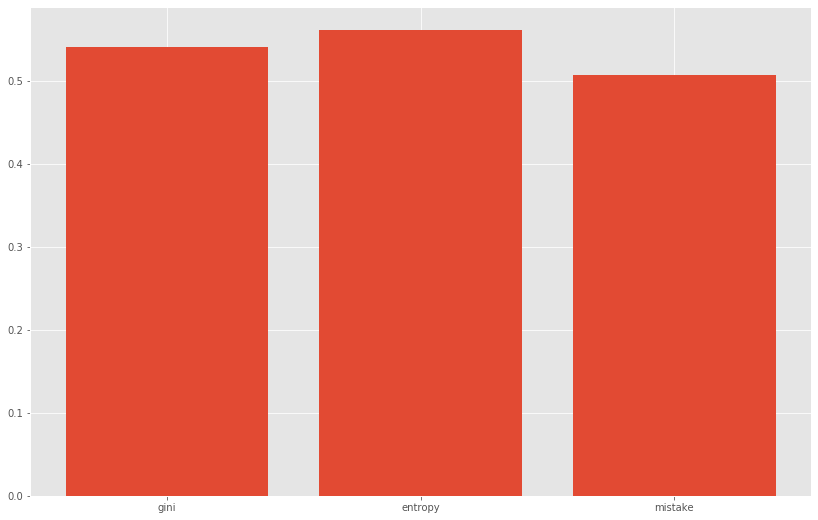

In [412]:
fig = plt.figure(figsize=(14,9))
plt.bar(['gini', 'entropy', 'mistake'], roc_aucs)
plt.xticks(['gini', 'entropy', 'mistake'])

2. Глубина дерева

In [413]:
params = {'max_depth': 0, 'criterion': 'entropy'}
roc_aucs = []

for i in range(2, 20):
    params['max_depth'] = i
    roc_aucs.append(get_roc_auc_mean(**params))

([<matplotlib.axis.XTick at 0x2ebfa360948>,
 <a list of 18 Text xticklabel objects>)

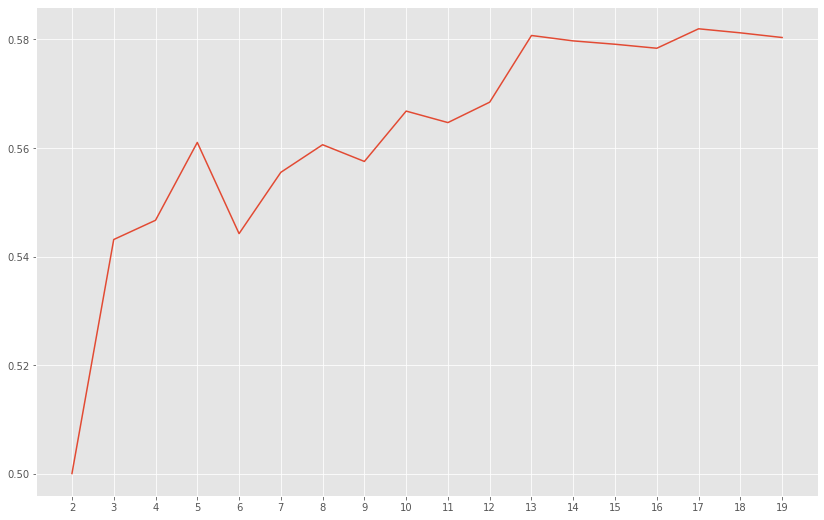

In [414]:
fig = plt.figure(figsize=(14,9))
plt.plot(range(2, 20), roc_aucs)
plt.xticks(range(2, 20))

In [416]:
params = {'min_samples_split': 2, 'max_depth': 17, 'criterion': 'entropy'}
roc_aucs = []

for i in range(2, 50, 2):
    params['min_samples_split'] = i
    roc_aucs.append(get_roc_auc_mean(**params))

([<matplotlib.axis.XTick at 0x2eb85d47488>,
 <a list of 24 Text xticklabel objects>)

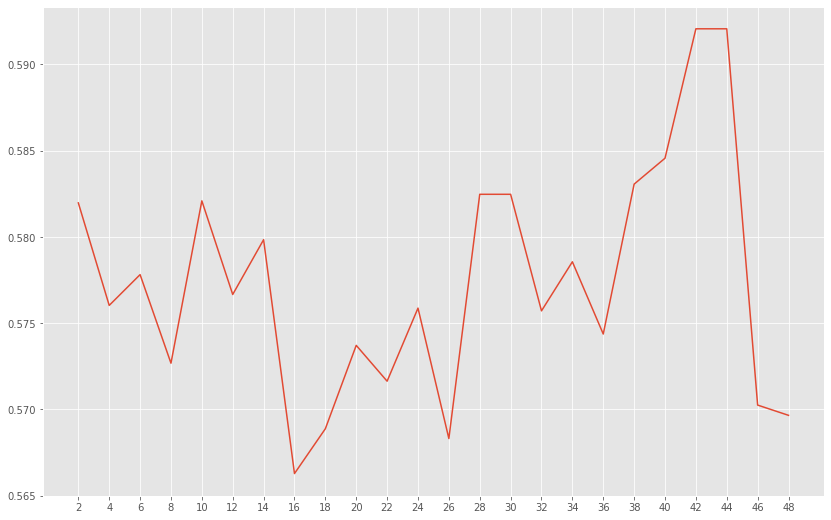

In [417]:
fig = plt.figure(figsize=(14,9))
plt.plot(range(2, 50, 2), roc_aucs)
plt.xticks(range(2, 50, 2))

Посомтрим, что вышло в итоге:

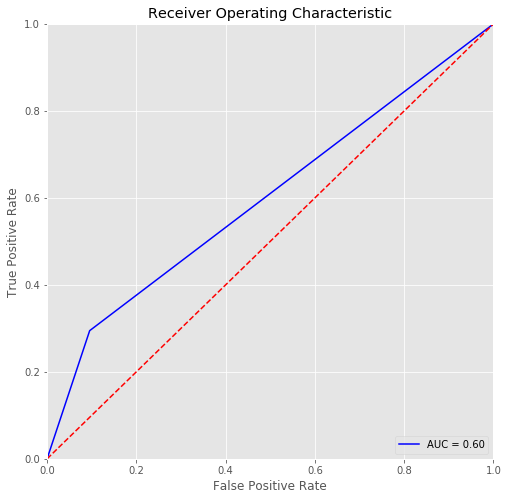

In [426]:
params = {'min_samples_split': 43, 'max_depth': 17, 'criterion': 'entropy'}
final_model = MyDecisionTreeClassifier(**params)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3456)

final_model.fit(x_train, y_train)
y_pred_ = final_model.predict(x_test)

fpr, tpr, thr = metrics.roc_curve(y_test, y_pred_)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize=(8,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

\# Это уже сделано выше, поэтому я просто повторю блок, который выводит ответ

In [428]:
feat_imps = np.array(list(final_model.get_feature_importance().values()))
inds = np.argsort(feat_imps)[::-1]
used_inds_sorted = inds[feat_imps[inds] > 0]

print('Признаки в порядке убывания важности:')
for feat in X.columns[used_inds_sorted].values:
    print(feat)

Признаки в порядке убывания важности:
attr5_1
field_6_f
sports
intel3_1
exercise_f
fun4_1_f
movies_f
movies
intel5_1
fun5_1_f
prob_o
career_6
age
clubbing
imprace_f
shar4_1
intel5_1_f
like_o
exercise
attr2_1_f
attr_o
theater_f
shar_o_f
reading_f
fun_o
career_11_f
gaming
attr1_1_f
age_f
amb4_1_f
field_4_f
clubbing_f
shar_o
int_corr
other
income_f
amb1_1_f
fun_o_f


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



1. Непонятно, как ускорять(
2. Я пробовал выделять разные признаки из существующих - как с учетом интересов, так и по attr1-attr5.
   Ничего толкового не выходило. Можно ли найти такой(ие) признаки? 